In [1]:
"""
------------------------
Last Updated: 26/03/2021
------------------------

------------------------------------
THIS NOTEBOOK NEEDS TO BE ORGANIZED 
-----------------------------------

The purpose of this notebook is to get a idea of how the translation of the smiles to 
the coarse-grained beads of Martini can work. 

-> https://cedric.bouysset.net/blog/2020/08/07/rdkit-interoperability

-> https://stackoverflow.com/questions/47319238/python-plot-3d-vectors
 
-> https://en.wikipedia.org/wiki/XYZ_file_format - information on the xyz coordination file 

-> https://mattermodeling.stackexchange.com/questions/3961/recalculate-atom-positions-to-account-for-periodic-boundary-conditions/3970#3970  - Atomsk

-> https://stackoverflow.com/questions/49064611/how-to-find-different-groups-in-networkx-using-python - grouping networks 

-> https://www.mdanalysis.org/2020/08/29/gsoc-report-cbouy/

-> http://cgmartini.nl/index.php/component/kunena/8-martini-philosophy/5776-mapping-of-benzene-ring

-> https://docs.mdanalysis.org/1.0.0/documentation_pages/lib/NeighborSearch.html

-> https://math.stackexchange.com/questions/180418/calculate-rotation-matrix-to-align-vector-a-to-vector-b-in-3d

-> https://sphinxcontrib-napoleon.readthedocs.io/en/latest/example_numpy.html

-> https://nanotube.msu.edu/fullerene/fullerene-isomers.html

-> https://towardsdatascience.com/molecular-visualization-in-streamlit-using-rdkit-and-py3dmol-part-2-657d28152753

-> https://plotly.com/python/3d-scatter-plots/

-> https://undergroundmathematics.org/circles/cutting-spheres/solution

-> https://www.ossila.com/products/pc70bm - pcbm 

-> https://github.com/mosdef-hub/nanoparticle_optimization

-> https://pubs.acs.org/doi/10.1021/acs.jctc.8b01269

Quote by Riccardo: 
------------------

In the open beta of Martini 3, benzene is indeed mapped with three TC4 beads, that that's again a 2-to-1 mapping. 
The bond length is changed to 0.29 nm in 3.0 because this allows to represent more closely the volume of a benzene 
molecule, taking into account also the smaller size of T-beads as compared to S -beads


---------------------------
How the modules are divided
---------------------------

-> We want to be given free reign into making NPs of multiple types. The primary types we are concerned with at the 
   moment is 

   1. Functionalized AuNP type ones.  
   2. Carbon Nanotube like ones. 
   3. Large spherical buckyball type structures - Like C70. 

-> TODO 
    
   - Am not able to get the box dimenisons correct for the xyz file...
   - Need to write Striped/Janus functionality to the NP maker  


Trying to translate the atomic C70 structure into the coarse-grained c70 structure 

TODO - isolate per 2 beads - There is a two to one mapping, and find the center of mass 
       for each of these beads. Then construct the itp file for the bead. 

"""

"\n------------------------\nLast Updated: 26/03/2021\n------------------------\n\n------------------------------------\nTHIS NOTEBOOK NEEDS TO BE ORGANIZED \n-----------------------------------\n\nThe purpose of this notebook is to get a idea of how the translation of the smiles to \nthe coarse-grained beads of Martini can work. \n\n-> https://cedric.bouysset.net/blog/2020/08/07/rdkit-interoperability\n\n-> https://stackoverflow.com/questions/47319238/python-plot-3d-vectors\n \n-> https://en.wikipedia.org/wiki/XYZ_file_format - information on the xyz coordination file \n\n-> https://mattermodeling.stackexchange.com/questions/3961/recalculate-atom-positions-to-account-for-periodic-boundary-conditions/3970#3970  - Atomsk\n\n-> https://stackoverflow.com/questions/49064611/how-to-find-different-groups-in-networkx-using-python - grouping networks \n\n-> https://www.mdanalysis.org/2020/08/29/gsoc-report-cbouy/\n\n-> http://cgmartini.nl/index.php/component/kunena/8-martini-philosophy/5776-ma

In [2]:
# Boilerplate libraries                                                                                                                                                                                    
import sys                                                                                                                                                                                                 
import re                                                                                                                                                                                                  
import math 

# Rdkit libraries 
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
from rdkit import Chem
from rdkit.Chem import AllChem                                                                                                                                                                             
from rdkit.Chem import ChemicalFeatures                                                                                                                                                                    
from rdkit.Chem import rdchem                                                                                                                                                                              
from rdkit.Chem import rdMolDescriptors                                                                                                                                                                    
from rdkit import RDConfig  

# Alignment libraries in MDAnalysis
import MDAnalysis as mda
from MDAnalysis.analysis import align
from MDAnalysis.analysis.rms import rmsd
from MDAnalysis.tests.datafiles import PSF, DCD, PDB_small, PDB, XTC

# Scipy libraries
import scipy                                                                                                                                                                                                                                                                                                                                                                                                          
from scipy.sparse import csr_matrix                                                                                                                                                                        
from scipy.sparse.csgraph import floyd_warshall                                                                                                                                                            
from scipy.spatial import ConvexHull, convex_hull_plot_2d 
from scipy.linalg import solve
from scipy.spatial import distance

# Matplotlib libraries 
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import axes3d    
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objs as go

# Pandas 
import pandas as pd
import numpy as np
import plotly.graph_objs as go
import math 
from operator import itemgetter
import itertools                                                                                                                                                                                           
import requests                                                                                                                                                                                            
import collections                                                                                                                                                                                         
import random               
        
import plotly.express as px

pd.set_option('display.max_colwidth', None)

IPythonConsole.ipython_useSVG=True  #< set this to False if you want PNGs instead of SVGs

In [3]:

def GetRingSystems(mol, includeSpiro=False):
    """
    What is this function doing?
    """
    ri = mol.GetRingInfo() # Sets out the indices of the rings structures within the mol file 
    systems = []
    for ring in ri.AtomRings():
        ringAts = set(ring)
        nSystems = []
        for system in systems:
            nInCommon = len(ringAts.intersection(system))
            if nInCommon and (includeSpiro or nInCommon>1):
                ringAts = ringAts.union(system)
            else:
                nSystems.append(system)
        nSystems.append(ringAts)
        systems = nSystems
    return systems

"""
Plotting functions 
"""

def mol_with_atom_index(mol):
    """
    
    """
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""
    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()
    

def fibonacci_sphere(samples=1):
    """
    Return a Fibanocci sphere with N number of points on the surface. 
    This will act as the template for the nanoparticle core. 
    """
    points = []
    phi = math.pi * (3. - math.sqrt(5.))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2  # y goes from 1 to -1
        radius = math.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = math.cos(theta) * radius
        z = math.sin(theta) * radius

        points.append((x, y, z))

    return points


"""
---------------------------------
Actual NP construction functions 
---------------------------------
"""
def rotation_matrix_from_vectors(vec1, vec2):
    """ 
    Description
    ------------
    Find the rotation matrix that aligns vec1 to vec2
    
    Parameters
    ----------
    
    vec1: 
        A 3d "source" vector
    vec2: 
        A 3d "destination" vector
    
    Returns
    -------
    rotation_matrix:
        A transform matrix (3x3) which when applied to vec1, aligns it with vec2.
    """
    a, b = (vec1 / np.linalg.norm(vec1)).reshape(3), (vec2 / np.linalg.norm(vec2)).reshape(3)
    v = np.cross(a, b)
    c = np.dot(a, b)
    s = np.linalg.norm(v)
    kmat = np.array([[0, -v[2], v[1]], [v[2], 0, -v[0]], [-v[1], v[0], 0]])
    rotation_matrix = np.eye(3) + kmat + kmat.dot(kmat) * ((1 - c) / (s ** 2))
    return rotation_matrix

def GenerateCore(Radius, N):
    """
    Description 
    -----------
    
    Parameters
    ----------
    Radius: 
        path and file where the pdb file is.
    N: 
        Placeholder 
        
    Creates a Fibanocci sphere that represents the NP core 
    and Allocates the radius. Using the radius, the core is scaled down/up 
    to the size that one wishes to have. 
    
    """
    Sphere = fibonacci_sphere(N) # Create the fibanocci sphere representing the NP core 
    XSphere, YSphere, ZSphere  = [], [], []
    for entry in Sphere:
        XSphere.append(entry[0])
        YSphere.append(entry[1])
        ZSphere.append(entry[2])
    # Append as 2d list
    SphereList = [] 
    for index in range(0, len(XSphere)):
        SphereList.append([XSphere[index], YSphere[index], ZSphere[index]])
    # Take the radius value, and then multiply the unit vector in each 
    # Direction by that radius value to increase the total volume of the 
    # NP core.
    for index in range(0, len(SphereList) -1):
        SphereList[index][0] = SphereList[index][0] * Radius
        SphereList[index][1] = SphereList[index][1] * Radius
        SphereList[index][2] = SphereList[index][2] * Radius
    return SphereList

def AttachLigands(LigandSmilesString, FirstAtomList, LastAtomList, SphereList):
    """
    Description
    -----------
    
    Parameters
    ----------
    LigandSmilesString: 
        smiles of the ligand we want to attach 
    FirstAtomList:
        Placeholder
    LastAtomList: 
        Placeholder
    Core:
        Placeholder 
    """
    # Through MDAnalysis 
    u = mda.Universe.from_smiles(LigandSmilesString) # Get the smiles string and change it to MDAnaly
    Molecule = u.select_atoms('all')
    # Select Atom attached to the core 
    FirstAtom = u.select_atoms('name {}'.format(FirstAtomList[0])) # Pick out the atoms attached
    # Select end atom on the ligand 
    LastAtom = u.select_atoms('name {}'.format(LastAtomList[0])) # Pick out the last atom at the tip of the ligand 
    TransformationList, NameList = [], []
    # Find the vector representing the direction from the sulfur to the tip of the ligand. 
    LigandAlignmentVector = (FirstAtom.positions- LastAtom.positions)[0]  
     
    for i,j in enumerate(Molecule.positions):
        vector = (j - FirstAtom.positions)[0]
        vector[0] = LigandAlignmentVector[0] - vector[0]
        vector[1] = LigandAlignmentVector[1] - vector[1]    
        vector[2] = LigandAlignmentVector[2] - vector[2]
        if vector[0] == -math.inf:
            pass
        if vector[0] == 0.0:
            pass
        else:
            TransformationList.append([vector, Molecule.atoms[i].type])        

    LigandList = [] 
    Sphere = []
    Xplot, Yplot, Zplot = [], [], []
    XplotSphere, YplotSphere, ZplotSphere = [], [], []

    # Sulfur/ligand vector 
    unitVector = np.linalg.norm(LigandAlignmentVector)
    vec1 = LigandAlignmentVector.tolist()
    for index in range(0, len(SphereList)):
        vec2 = SphereList[index] 
        # Find the rotation matrix that aligns ligand vector representation to the NP surface vector point representation 
        TransformationVector = rotation_matrix_from_vectors(vec1, vec2)  
        vec1_rot = TransformationVector.dot(vec1) # Rotate the vector to match the surface point on the sphere 
        # TODO 
        unitVectorabs = np.linalg.norm(LigandAlignmentVector)  
        vecMultiplier = vec1_rot/unitVectorabs * 3 # Controls how far we want the ligands to be placed away from
                                               # the NP surface
        # TODO
        Sphere.append(vec1_rot.tolist())
        #LigandList.append(vec1_rot.tolist())
        # Get the factors to translate the vector 
        for trans in TransformationList:
            #if vec1_rot[0] > 0 and vec1_rot[1] > 0 and vec1_rot[2] > 0:   # (+ , +, +)
            LigandAtomcoordinate = TransformationVector.dot(trans[0])
            LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
            LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
            LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
            LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
            NameList.append(trans[1]) # Append the names of the atoms 

    # Append the coordinates of the ligands 
    for index, entry in enumerate(LigandList):
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        Xplot.append(entry[0])
        Yplot.append(entry[1])
        Zplot.append(entry[2])
    # Add in the ligand index 
    LigandConstituent = [atom.name for atom in Molecule]
    Ligands = []
    for index in range(0, len(Sphere)): 
        Ligands = Ligands + LigandConstituent
    
    SphereName = [] 
    # Append the coordinates of the sphere 
    for entry in Sphere:
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        XplotSphere.append(entry[0])
        YplotSphere.append(entry[1])
        ZplotSphere.append(entry[2])
        SphereName.append('Au')
    
    dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
    dfLigand['name'] = 'Ligand'
    dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
    dfCore['name'] = 'Core'
    Total = dfLigand.append(dfCore)
    return Total

def ReadMartiniMolecules(GroFile, First, Last):
    """
    Description
    -----------
    
    Access the Martini3 small molecules library and 
    
    One needs to describe the attaching bead to the main core and the atom furthest away from the 
    core, to create the directional vector to which the struture will be placed on the surface of the NP 
    core. 
      
    """
    #GroPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/gros"
    #ItpPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono"
    u = mda.Universe(GroFile)
    ids = [i.name for i in u.atoms]
    TransformationList= []
    Molecule = u.select_atoms('all')
    # In this case, the atoms will be N1 and R3 
    FirstAtom = u.select_atoms('name {}'.format(First)) # Pick out the atoms attached
    #LastAtom = u.select_atoms('name {}'.format(Last)) # Pick out the atoms attaached
    LastAtom = Molecule.center_of_mass()
    #LigandAlignmentVector = (FirstAtom.positions - LastAtom.positions)[0]    
    LigandAlignmentVector = (FirstAtom.positions - LastAtom)[0]  
    for i,j in enumerate(Molecule.positions):
        vector = (j - FirstAtom.positions)[0]
        vector[0] = LigandAlignmentVector[0] - vector[0]
        vector[1] = LigandAlignmentVector[1] - vector[1]    
        vector[2] = LigandAlignmentVector[2] - vector[2]
        if vector[0] == -math.inf:
            pass
        if vector[0] == 0.0:
            pass
        else:
            TransformationList.append([vector, Molecule.atoms[i].type])    
    return Molecule, TransformationList, LigandAlignmentVector 

#PandasNPDataframe = AttachLigands('C1=C(C=CC=C1)CS[H]', ['S7'], ['C4'], SphereList)
def AttachLigandsMartini(GroFile, FirstAtom, LastAtom, SphereList):
    """
    Description
    -----------

    """
    Molecule, TransformationList, LigandAlignmentVector = ReadMartiniMolecules(GroFile, FirstAtom, LastAtom)
    LigandList, NameList = [], []
    Sphere = []
    Xplot, Yplot, Zplot = [], [], []
    XplotSphere, YplotSphere, ZplotSphere = [], [], []

    # Sulfur/ligand vector 
    unitVector = np.linalg.norm(LigandAlignmentVector)
    vec1 = LigandAlignmentVector.tolist()
    for index in range(0, len(SphereList)):
        vec2 = SphereList[index] 
        # Find the rotation matrix that aligns ligand vector representation to the NP surface vector point representation 
        TransformationVector = rotation_matrix_from_vectors(vec1, vec2)  
        vec1_rot = TransformationVector.dot(vec1) # Rotate the vector to match the surface point on the sphere 
        # TODO 
        unitVectorabs = np.linalg.norm(LigandAlignmentVector)  
        vecMultiplier = vec1_rot/unitVectorabs * 2 # Controls how far we want the ligands to be placed away from
                                               # the NP surface
        # TODO
        Sphere.append(vec1_rot.tolist())
        #LigandList.append(vec1_rot.tolist())
        # Get the factors to translate the vector 
        for trans in TransformationList:
            #if vec1_rot[0] > 0 and vec1_rot[1] > 0 and vec1_rot[2] > 0:   # (+ , +, +)
            LigandAtomcoordinate = TransformationVector.dot(trans[0])
            LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
            LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
            LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
            LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
            NameList.append(trans[1]) # Append the names of the atoms 

    # Append the coordinates of the ligands 
    for index, entry in enumerate(LigandList):
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        Xplot.append(entry[0])
        Yplot.append(entry[1])
        Zplot.append(entry[2])
    # Add in the ligand index 
    LigandConstituent = [atom.name for atom in Molecule]
    Ligands = []
    for index in range(0, len(Sphere)): 
        Ligands = Ligands + LigandConstituent
    
    SphereName = [] 
    # Append the coordinates of the sphere 
    for entry in Sphere:
        #ax.plot3D(entry[0], entry[1], entry[2], 'red')
        XplotSphere.append(entry[0])
        YplotSphere.append(entry[1])
        ZplotSphere.append(entry[2])
        SphereName.append('Au')
    
    dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
    dfLigand['name'] = 'Ligand'
    dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
    dfCore['name'] = 'Core'
    Total = dfLigand.append(dfCore)
    return Total
    
def ComputeC70Distances(coordinate):
    """    
    Parameters
    ----------
    coordinate: 
        path and file where the pdb file is.
    
    """
    u = mda.Universe(coordinate)
    
    CorePositions, CoreIndex = [], []
    C70CGBeadPositions = []
    DistanceDict = {}
    CorePositions = [[index, atoms.position] for index, atoms in enumerate(u.atoms)]
    
    for index, atoms in enumerate(u.atoms): # iterate through items 
        DistanceDict[index] = []
        # Get the distance between atoms in the core positions  
        for items in CorePositions:
            # Find the distance between the index atoms in the index, atom.. 
            # and the core 
            dist = distance.euclidean(items[1], atoms.position)
            Entry = [index, items[0], dist]
            # Sort entry by dist 
            DistanceDict[index].append(Entry)
    ClosestAtomsDistance = [] # List to store the atoms with the closest distances
    # Sort each entry by distance 
    
    for key in DistanceDict.keys():
        DistanceDict[key] = sorted(DistanceDict[key], key=itemgetter(2)) # sort entries by closest distance 
        DistanceDict[key][1][0:2] = sorted(DistanceDict[key][1][0:2]) # 
        ClosestAtomsDistance.append(DistanceDict[key][1])
    # Remove duplicate entries 
    UniqueSetsCoordinates = [list(x) for x in set(tuple(x) for x in ClosestAtomsDistance)]       
    # Take the indices in the unique data and compute the averge coordinates
    
    for entry in UniqueSetsCoordinates:
        data = [list(CorePositions[entry[0]][1]), list(CorePositions[entry[1]][1])]
        averaged = np.average(data, axis=0)
        C70CGBeadPositions.append(averaged)
        
    return C70CGBeadPositions


def GenerateXYZ(NPDataframe, name):
    """
    Parameters
    ----------
    Generate xyz structure coordinates from 
    the made NP. 
    """
    with open(name, 'w') as xyz_file:
        xyz_file.write("%d\n%s\n" % (len(NPDataframe), 'NP'))
        for index, row in NPDataframe.iterrows():
            xyz_file.write("{:4} {:11.6f} {:11.6f} {:11.6f}\n".format(
                row['NAME'], row['X'], row['Y'], row['Z']))
    

In [4]:
# Generate the Striped version of this NP. 

def LabelStripedNP(Core, Type = 'Janus'):
    """
    Description
    -----------
    
    Depending on the type of NP we want in the input, we can try to generate 
    different patterns on the surface of the spehre, which will help us generate the 
    
    The types of NPs we can currently have are:
    
    - Janus 
    - Striped
    - Mono 
    - Random 
    
    -> The Janus type divides the NP into two hemispheres
    
    -> The Striped type divides the NP into three hemispheres, typically used with a hydrophobic middle 
    especially when it comes to using with biosimulations
    
    -> The Mono type is simple a single ligand attached, so no modification is required
    
    -> The Random type randomly distributes multiple types of the ligands on the surface of the NP sphere 
    
    """
    XCoordinates = [i[0] for i in Core] # Find x coordinates
    YCoordinates = [i[1] for i in Core] # Find y coordinates
    ZCoordinates = [i[2] for i in Core] # Find z coordinates 
    Length = 2 * abs(max(ZCoordinates))
    
    if Type == 'Striped':
        # As we have a spherical structure, we just need to find the minimum/maximum in 
        # one of the axes to find that for the rest 
        # define the threshold for how you wish to generate the NP with striped pattern 
        Threshold = Length / 3 
        # Find the central band of the sphere where you wish to put 
        # different ligands 
        StripedValues = [i for i in Core if i[2] > (min(ZCoordinates) + Threshold) and i[2] < (max(ZCoordinates) - Threshold)] # Return middle strip
        CeilingValues = [i for i in Core if i not in StripedValues] # Return top 'ceiling' values 
        return StripedValues, CeilingValues
    elif Type == 'Janus':
        Threshold = Length / 2 
        TopValues = [i for i in Core if i[2] > (min(ZCoordinates) + Threshold)]
        BotValues = [i for i in Core if i not in TopValues]
        return TopValues, BotValues
        
A, B = LabelStripedNP(GenerateCore(10, 100), 'Janus') # Janus example
C, D = LabelStripedNP(GenerateCore(10, 100), 'Striped') # Janus example

In [5]:
def GenerateNPITP():
    """
    Description
    -----------
    Code to generate the bond restraints where PyCGtools do not seem to be adequate. Not a 
    critcism of PyCGTools, but that it is perhaps not designed to optimize NP structures 
    
    """


"""
Author: Sang Young Noh
----------------------

Last Updated: 31/05/2021
------------------------

Code to generate the bond restraints where PyCGtools do not seem to be adequate. Not a 
cricism of PyCGTools, but that it is perhaps not designed to optimize NP structures 

For the CA CA bonds

CA CA         1    0.14000   392459.2 ; 7,(1986),230; BENZENE,PHE,TRP,TYR ; This is the amber aa - between aromatic AA
CA S          1    0.17500   189953.6 ; Au_cluster_ff ; This is the parameters for the amber aa - between aromatic AA and Sulfer

"""
## Module imports

import numpy as np 
import MDAnalysis
from MDAnalysis.analysis.distances import distance_array

universe = MDAnalysis.Universe("out.gro") ## Reading in the .gro file5
# Ligand attached P5 atoms
P5Atoms = universe.select_atoms("name P5")
P5ID = P5Atoms.atoms.ids
# ST atoms 
STAtoms = universe.select_atoms("name SB0 PB0")
STID = STAtoms.atoms.ids
# BEN ligands - Aromatic ligands 
PETAtoms = universe.select_atoms("resname PET")
PETID = PETAtoms.atoms.ids
# BEN ligands - Polar ligands
SAtoms = universe.select_atoms("resname S")
SID = SAtoms.atoms.ids

P5AtomsPositionArray = P5Atoms.positions # Core atoms
STAtomsPositionArray = STAtoms.positions # Sulfur atoms
PETAtomsPositionArray = PETAtoms.positions # Hydrophobic ligand atoms 
SAtomsPositionArray = SAtoms.positions # Polar ligands atoms 

# Print out whole index
# We follow the format of the NP_template of the previous MARTINI NP I made
# which has the following format:

"""
How to print out the atoms part of the itp file5

[ moleculetype ]
NP             1

[ atoms ]
; nr  type  resnr residue atom cgnr charge  mass
     1       P5        1   NP   P5        1    0.0000    30.9738
     2       C1        1   NP   C1        2    0.0000    12.0110
     3       C2        1   NP   C2        3    0.0000    12.0110
     4       Qa        1   NP   Qa        4    0.0000    12.0000
     5       P5        1   NP   P5        5    0.0000    30.9738
     6       C1        1   NP   C1        6    0.0000    12.0110
     7       C2        1   NP   C2        7    0.0000    12.0110
"""
"""
Commentary on the masses of the beads 
In the case of 
"""

#BeadDict = {'P5': 'TC6', 'SB0' : 'TC6', 'SB1' : 'P5', 'SB2' : 'SC4', 'SB3' : 'TP1', 'SB4' : 'TP1', 'SB5': 'TP1', 'SB6' : 'TC3', 'PB0' : 'TC6', 'PB1' : 'TC2', 'PB2' : 'TC2', 'PB3' : 'TC5', 'PB4' : 'TC5', 'PB5' : 'TC5' } # Dict to store name and type of the MARTINI beads used for making

#BeadMass = {'P5' : 33.0, 'SB0' : 33.0, 'SB1' : 43.0, 'SB2' : 25.0, 'SB3' : 28.0, 'SB4' : 28.0, 'SB5' : 28.0, 'SB6': 14.0 , 'PB0' : 30.0, 'PB1' : 14.0, 'PB2': 14, 'PB3' : 15, 'PB4': 26, 'PB5': 26} # Dict to store name and mass of the MARTINI beads used for making the CG NP 

BeadDict = {'P5': 'C6', 'SB0' : 'C6', 'SB1' : 'P5', 'SB2' : 'SC3', 'SB3' : 'TP1', 'SB4' : 'TP1', 'SB5': 'TP1', 'SB6' : 'TC3', 'PB0' : 'C6', 'PB1' : 'SC4', 'PB2' : 'TC2', 'PB3' : 'TC5', 'PB4' : 'TC5', 'PB5' : 'TC5' } # Dict to store name and type of the MARTINI beads used for making
BeadMass = {'P5' : 196.96, 'SB0' : 33.0, 'SB1' : 43.0, 'SB2' : 25.0, 'SB3' : 28.0, 'SB4' : 28.0, 'SB5' : 28.0, 'SB6': 14.0 , 'PB0' : 30.0, 'PB1' : 28.0, 'PB2': 14, 'PB3' : 15, 'PB4': 26, 'PB5': 26} # Dict to store name and mass of the MARTINI beads used for making the CG NP

print ('[ moleculetype ]')
print ('NP     1')
allAtoms = universe.select_atoms('all')
print ("[ atoms ]")
print ("; nr  type  resnr residue atom cgnr charge  mass")
for row in allAtoms:
    print ("     {}       {}        {}   {}   {}        {}    {}    {}".format(row.id, BeadDict[row.name], 1, 'NP', row.name, row.id, 0.000, BeadMass[row.name]))

"""
 We want to print out bond restraints in the following format:

index, index2, bond type (?), distance, spring constant. For example: 

[ bonds ]
1 785  1 0.20        5000			
1 397  1 0.20        5000

# ----------------------------------------------------------------
##  As for angular restraints, we want them to be printed out as:
# -------------------------------------------------------- #
# index, index2, index3, bond type (?), angle, spring constant  #
# -------------------------------------------------------- #
#[ angles ]
#2 3 4 2 180 25
#6 7 8 2 180 25
#10 11 12 2 180 25
#14 15 16 2 180 25

"""
# Some sanity checks - Check that the number of ids selected actually match the number of atoms within the array 
assert (len(P5ID) == len(P5AtomsPositionArray))
assert (len(STID) == len(STAtomsPositionArray))
assert (len(PETID) == len(PETAtomsPositionArray))

#print (STID, P5ID)

## Find the closest ST group to the Gold Core  
print ('[ bonds ]')
print('; i  j  func')
print ('; P5 - P5 ')
DuplicateArray = []
for index, atom in enumerate(P5AtomsPositionArray): # Loop over the P5 position array                                                                                                                       
        distarray = (distance_array(atom, P5AtomsPositionArray)) # Find the distance between the P5 atoms and the selected index                                                                            
        for index2, entry in enumerate(distarray[0]):
                if index == index2: # If we are looking at the same index (same P5 atom), then pass                                                                                                         
                       pass
                else:
                        if distarray[0][index2]/10 >= 0.7: # If the length of the bonds is more than 0.7, then pass - dont use that bond                                                                   
	                        pass
                        elif index == 1:
                                print (P5ID[index], P5ID[index2], 1, distarray[0][index2]/10, 5000) # Else, allocate a strong contraint between the P5 files to hold the core together                     
                                sortedInput = [P5ID[index], P5ID[index2]]
                                sortedInput.sort()
                                DuplicateArray.append(sortedInput)
                        elif index > 1:
                                sortedInput = [P5ID[index], P5ID[index2]]
                                sortedInput.sort()
                                if sortedInput in DuplicateArray: # if already contained in array, then dont do anything                                                                                   
                                        pass
                                else:
                                        print (P5ID[index], P5ID[index2], 1, distarray[0][index2]/10, 5000) # The ones printed out here has gone through the check of the duplicates so print              
                                        DuplicateArray.append(sortedInput) # Store the combination to make sure it is checked for duplicates as it goes down                                                





#for index, atom in enumerate(P5AtomsPositionArray): # Loop over the P5 position arrays
#	distarray = (distance_array(atom, P5AtomsPositionArray)) # Find the distance between the P5 atoms and the selected index 
#	for index2, entry in enumerate(distarray[0]):
#		if index == index2: # If we are looking at the same index (same P5 atom), then pass. 
#			pass
#		else:
#			print (P5ID[index], P5ID[index2], 1, distarray[0][index2]/10, 1000) # Else, allocate a strong contraint between the P5 files to hold the core together 

# Now to identify the gold core atoms that are the closest to the sulfer atoms  
print ('; ST - P5 ')  
for index, atom in enumerate(STAtomsPositionArray): # Loop over the sulfer atoms                     
    distarray = (distance_array(atom, P5AtomsPositionArray)) # Find the shortest distance between the ST and the appropriate gold core and allocate the print                                         
    for NPindex, entry in enumerate(distarray[0]):
            if entry/10 <= 0.34:
                print (STID[index], P5ID[NPindex], 1, entry/10, 5000)


# Allocate the bond parameters for the hydrophobic ligands 
print ('; PET ligands ')
"""
<AtomGroup [<Atom 181: PB0 of type P of resname PET, resid 85 and segid SYSTEM>, <Atom 182: PB1 of type P of resname PET, resid 85 and segid SYSTEM>, <Atom 183: PB2 of type P of resname PET, resid 85 and segid SYSTEM>, <Atom 184: PB3 of type P of resname PET, resid 85 and segid SYSTEM>, <Atom 185: PB4 of type P of resname PET, resid 85 and segid SYSTEM>, <Atom 186: PB5 of type P of resname PET, resid 85 and segid SYSTEM>]>

[PET]
PB0 PB1
PB1 PB2
PB2 PB3
PB3 PB4
PB4 PB5
PB5 PB3
"""
for res in PETAtoms.residues:
    # First index is ST, second SC1, third SC2 and fourth SC4
    ligandResIDS = res.atoms.ids 
    #	print (ligandsResIDS)
    print (ligandResIDS[0], ligandResIDS[1], 1, 0.216, 5000) #  ST - C1  
    print (ligandResIDS[1], ligandResIDS[2], 1, 0.225, 5000) #  C1 - C2
#        print (ligandResIDS[2], ligandResIDS[3], 1, 0.2179, 5000.2) #  C2 - C3 
#        print (ligandResIDS[3], ligandResIDS[4], 1, 0.2220, 5000.2)
#        print (ligandResIDS[4], ligandResIDS[2], 1, 0.2220, 5000.2)
        
# Allocate the bond parameters for the polar ligands 
print ('; S ligands ')
"""
<AtomGroup [<Atom 69: SB0 of type S of resname S, resid 69 and segid SYSTEM>, <Atom 70: SB1 of type S of resname S, resid 69 and segid SYSTEM>, <Atom 71: SB2 of type S of resname S, resid 69 and segid SYSTEM>, <Atom 72: SB3 of type S of resname S, resid 69 and segid SYSTEM>, <Atom 73: SB4 of type S of resname S, resid 69 and segid SYSTEM>, <Atom 74: SB5 of type S of resname S, resid 69 and segid SYSTEM>, <Atom 75: SB6 of type S of resname S, resid 69 and segid SYSTEM>]>

[S]
SB0 SB1 
SB1 SB6  
SB1 SB3 
SB2 SB3
SB3 SB4
SB4 SB5
SB5 SB6

"""
for res in SAtoms.residues:
	# zeroth index is ST, first RA, second R1, third R2 and fourth R3	
        ligandResIDS = res.atoms.ids
        #	print (ligandsResIDS)
        #print (ligandResIDS[0], ligandResIDS[1], 1, 0.2400, 5000) # ST - RA 
        #print (ligandResIDS[1], ligandResIDS[2], 1, 0.2300, 5000) # SB2 -SB3
        print (ligandResIDS[0], ligandResIDS[1], 1, 0.2500, 5000) # ST - RA 
        print (ligandResIDS[1], ligandResIDS[2], 1, 0.2600, 5000) # SB2 -SB3
        print (ligandResIDS[2], ligandResIDS[3], 1, 0.3040, 5000) # SB5 - SB6
        print (ligandResIDS[2], ligandResIDS[4], 1, 0.2710, 5000) # SB4 - SB5 
        print (ligandResIDS[2], ligandResIDS[5], 1, 0.2850, 5000) # SB5 - SB1
        #print (ligandResIDS[1], ligandResIDS[3], 1, 0.3000, 5000) # SB2 - SB6 
        #print (ligandResIDS[2], ligandResIDS[4], 1, 0.2580, 5000) # SB3 - SB4 
        #print (ligandResIDS[4], ligandResIDS[5], 1, 0.2580, 5000) # SB4 - SB5 
        #print (ligandResIDS[5], ligandResIDS[6], 1, 0.2140, 5000) # SB5 - SB1
        #print (ligandResIDS[6], ligandResIDS[3], 1, 0.2310, 5000) # SB5 - SB6

print ('#ifndef FLEXIBLE')
print ('[ constraints ]')
print ('#endif')
for res in SAtoms.residues:
	# zeroth index is ST, first RA, second R1, third R2 and fourth R3	
        ligandResIDS = res.atoms.ids 
        #	print (ligandsResIDS)
        #print (ligandResIDS[0], ligandResIDS[1], 1, 0.2400, 5000.2) # ST - RA 
        #print (ligandResIDS[1], ligandResIDS[2], 1, 0.2160, 5000.2) # SB2 -SB3 
        #print (ligandResIDS[1], ligandResIDS[3], 1, 0.3000, 1000000.2) # SB2 - SB6 
        #print (ligandResIDS[2], ligandResIDS[4], 1, 0.2510, 1000000.2) # SB3 - SB4 
        #print (ligandResIDS[4], ligandResIDS[5], 1, 0.2580, 1000000.2) # SB4 - SB5 
        #print (ligandResIDS[5], ligandResIDS[6], 1, 0.2140, 1000000.2) # SB5 - SB1
        #print (ligandResIDS[2], ligandResIDS[3], 1, 0.3040, 1000000.2) # SB5 - SB6
        #print (ligandResIDS[2], ligandResIDS[4], 1, 0.2710, 1000000.2) # SB4 - SB5 
        #print (ligandResIDS[2], ligandResIDS[5], 1, 0.2850, 1000000.2) # SB5 - SB1
for res in PETAtoms.residues:
        # First index is ST, second SC1, third SC2 and fourth SC4
        ligandResIDS = res.atoms.ids 
        print (ligandResIDS[2], ligandResIDS[3], 1, 0.2179, 1000000.2) #  C2 - C3 
        print (ligandResIDS[3], ligandResIDS[4], 1, 0.2220, 1000000.2)
        print (ligandResIDS[4], ligandResIDS[2], 1, 0.2220, 1000000.2)

print ('[ angles ]')
for res in SAtoms.residues:
    # zeroth index is ST, first RA, second R1, third R2 and fourth R3	#
    ligandResIDS = res.atoms.ids
    print (ligandResIDS[0], ligandResIDS[1], ligandResIDS[2], 1, 165, 200) # ST - RA - R1  
    print (ligandResIDS[1], ligandResIDS[2], ligandResIDS[3], 1, 115, 200) # R1 - R2 - R3
    print (ligandResIDS[1], ligandResIDS[2], ligandResIDS[4], 1, 146, 200) # R2 - R3 - R1
    print (ligandResIDS[1], ligandResIDS[2], ligandResIDS[5], 1, 160, 200) # R2 - R3 - R1

"""
[angle1]
  1  2  3
[angle2]
  2  3  4
[angle3]
  3  4  5
[angle4]
  4  5  6
[angle5]
  6  4  3
"""
for res in PETAtoms.residues:
    # zeroth index is ST, first RA, second R1, third R2 and fourth R3	
    ligandResIDS = res.atoms.ids
    print (ligandResIDS[0], ligandResIDS[1], ligandResIDS[2], 1, 166, 200) # ST - C1 - C2 
    print (ligandResIDS[1], ligandResIDS[2], ligandResIDS[3], 1, 60, 200) # C1 - C2 - C3 
    print (ligandResIDS[3], ligandResIDS[4], ligandResIDS[2], 1, 58, 200) # C2 -  - R3
    ligandRes = res.atoms
        
#print ('; angles ')
#for index, atom in enumerate(STAtomsPositionArray):
#	distarray = (distance_array(atom, P5AtomsPositionArray))
#	print (P5ID[np.argmin(distarray)], STID[index], STID[index]+1, 1, 120, 25) # Explanation required 		

print('[ dihedrals ]')
for res in PETAtoms.residues:
    # zeroth index is ST, first RA, second R1, third R2 and fourth R3	
    ligandResIDS = res.atoms.ids
    print (ligandResIDS[1], ligandResIDS[2], ligandResIDS[3], ligandResIDS[4], 2, 0, 50) # ST - RA - R1  
    
    
#for res in SAtoms.residues:
## zeroth index is ST, first RA, second R1, third R2 and fourth R3	
#ligandResIDS = res.atoms.ids 	
#print (ligandResIDS[0], ligandResIDS[1], ligandResIDS[2], ligandResIDS[4], 2, 0, 50) # ST - RA - R1  

print('[ exclusions ]')
for res in PETAtoms.residues:
    ligandResIDS = res.atoms.ids
    print (ligandResIDS[0], ligandResIDS[1], ligandResIDS[2], ligandResIDS[3], ligandResIDS[4]) # ST - RA - R1  
    print (ligandResIDS[1], ligandResIDS[0], ligandResIDS[2], ligandResIDS[3], ligandResIDS[4]) # ST - RA - R1  
    print (ligandResIDS[2], ligandResIDS[0], ligandResIDS[1], ligandResIDS[3], ligandResIDS[4]) # ST - RA - R1  
    print (ligandResIDS[3], ligandResIDS[0], ligandResIDS[1], ligandResIDS[2], ligandResIDS[4]) # ST - RA - R1  
    print (ligandResIDS[4], ligandResIDS[0], ligandResIDS[1], ligandResIDS[2], ligandResIDS[3]) # ST - RA - R1
        
for res in SAtoms.residues:
    ligandResIDS = res.atoms.ids
    print (ligandResIDS[0], ligandResIDS[1], ligandResIDS[2], ligandResIDS[3], ligandResIDS[4], ligandResIDS[5]) # ST - RA - R1  
    print (ligandResIDS[1], ligandResIDS[0], ligandResIDS[2], ligandResIDS[3], ligandResIDS[4], ligandResIDS[5]) # ST - RA - R1  
    print (ligandResIDS[2], ligandResIDS[1], ligandResIDS[0], ligandResIDS[3], ligandResIDS[4], ligandResIDS[5]) # ST - RA - R1  
    print (ligandResIDS[3], ligandResIDS[1], ligandResIDS[2], ligandResIDS[0], ligandResIDS[4], ligandResIDS[5]) # ST - RA - R1  
    print (ligandResIDS[4], ligandResIDS[1], ligandResIDS[2], ligandResIDS[3], ligandResIDS[0], ligandResIDS[5]) # ST - RA - R1  
    print (ligandResIDS[5], ligandResIDS[1], ligandResIDS[2], ligandResIDS[3], ligandResIDS[4], ligandResIDS[0]) # ST - RA - R1  
        
for index, atom in enumerate(P5AtomsPositionArray): # Loop over the P5 position arrays
        P5IDTemp = np.delete(P5ID, index)
        print(P5ID[index], *P5IDTemp)
        
def GenerateItpNP(NPPandasTable):
    """
    Description
    -----------
    
    
    
    """
    
    

FileNotFoundError: [Errno 2] No such file or directory: 'out.gro'

In [7]:
# Visualizing the Striped NP example 
Carray = np.array(C)
Darray = np.array(D)
C_df = pd.DataFrame(Carray, columns =['X', 'Y', 'Z'])
D_df = pd.DataFrame(Darray, columns =['X', 'Y', 'Z'])

C_df['name'] = 'A'
D_df['name'] = 'B'

total_df = C_df.append(D_df)


fig = px.scatter_3d(total_df, x='X', y='Y', z='Z', color='name')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

In [24]:
def CreateNPITP(PandasNP):
    """
    
    """


print ('[ bonds ]') # itp file bonds part 
print('; i  j  func') # itp files index part 
print ('; P5 - P5 ') # Name of the inner atoms - for now we have the P5 beads 
DuplicateArray = []
# Need to translate 
NPData_Numpy = total_df.to_numpy()[:, :3]
for i1, j1 in enumerate(NPData_Numpy):
    for i2, j2 in enumerate(NPData_Numpy):
        if i1 == i2: 
            pass
        else:
            dst = distance.euclidean(j1, j2)
            if dst/10 >= 0.7: # If the length of the bonds is more than 0.7, then pass - dont use that bond 
                pass
            else:    
                print (i1, i2, 1, dst/10, 5000)
                sortedInput = [i1, i2]
                sortedInput.sort()
                DuplicateArray.append(sortedInput)

[ bonds ]
; i  j  func
; P5 - P5 
0 1 1 0.2010075630518425 5000
0 2 1 0.2842676218074806 5000
0 3 1 0.3481553119113955 5000
0 4 1 0.40201512610368473 5000
0 5 1 0.44946657497549475 5000
0 6 1 0.5685352436149613 5000
0 7 1 0.6030226891555273 5000
0 34 1 0.49236596391733095 5000
0 35 1 0.5318160234783105 5000
0 36 1 0.6356417261637282 5000
0 37 1 0.6666666666666666 5000
0 38 1 0.6963106238227914 5000
1 0 1 0.2010075630518425 5000
1 2 1 0.45007578152033545 5000
1 3 1 0.38363894685600125 5000
1 4 1 0.3208059016876549 5000
1 5 1 0.6409711069179003 5000
1 6 1 0.676456818788478 5000
1 7 1 0.425060615366336 5000
1 9 1 0.6947718950197607 5000
1 34 1 0.34187538292188685 5000
1 35 1 0.6088944238512826 5000
1 37 1 0.6077118472072034 5000
1 38 1 0.6613009188085098 5000
1 39 1 0.5677942585016644 5000
2 0 1 0.2842676218074806 5000
2 1 1 0.45007578152033545 5000
2 3 1 0.5825709142120326 5000
2 4 1 0.4653158708818377 5000
2 5 1 0.35313182390649833 5000
2 6 1 0.6860134274359766 5000
2 8 1 0.686344732207

44 4 1 0.6486755352944948 5000
44 9 1 0.6930927816265859 5000
44 11 1 0.4822741883617563 5000
44 35 1 0.41530331786998387 5000
44 38 1 0.3351288812822456 5000
44 40 1 0.444442109815604 5000
44 50 1 0.3513558194342456 5000
44 54 1 0.3518979002881168 5000
44 60 1 0.4767424772082428 5000
44 64 1 0.6792887341110124 5000
45 7 1 0.3963282388224542 5000
45 9 1 0.4605920856903151 5000
45 12 1 0.35573878600390174 5000
45 34 1 0.6455657368015002 5000
45 39 1 0.3384575520785505 5000
45 49 1 0.49512451032851174 5000
45 55 1 0.34870781005506585 5000
45 61 1 0.46931859361624306 5000
45 65 1 0.6763164630258345 5000
46 35 1 0.646913139198756 5000
46 36 1 0.3889158141245467 5000
46 40 1 0.34042209092122333 5000
46 42 1 0.4681510247622455 5000
46 50 1 0.5010920698558152 5000
46 52 1 0.35786492000473374 5000
46 56 1 0.3473861732803528 5000
46 62 1 0.46607823042971586 5000
46 66 1 0.6751083227834181 5000
47 3 1 0.6705914606653847 5000
47 6 1 0.6494160012922295 5000
47 37 1 0.38254751444057195 5000
47 41 1

90 89 1 0.6930927816265908 5000
90 94 1 0.41756782044279045 5000
90 96 1 0.33301828106238335 5000
90 99 1 0.4612587511178471 5000
91 24 1 0.6785318089353487 5000
91 30 1 0.4852589336842528 5000
91 72 1 0.6882766353831306 5000
91 76 1 0.49623364186615754 5000
91 80 1 0.6843393375457384 5000
91 82 1 0.3612658328944321 5000
91 86 1 0.3425097498737642 5000
91 88 1 0.4526913450618856 5000
91 93 1 0.6299188143435653 5000
91 95 1 0.40791042175369013 5000
91 97 1 0.3336829429889097 5000
92 21 1 0.6795897664068937 5000
92 23 1 0.3404220909212147 5000
92 25 1 0.66318559345498 5000
92 27 1 0.3979289426958199 5000
92 29 1 0.693274524819725 5000
92 31 1 0.5179153141707374 5000
92 73 1 0.691390220208518 5000
92 77 1 0.5023194649489048 5000
92 83 1 0.3644587187949783 5000
92 89 1 0.4444421098156188 5000
92 94 1 0.6118681023910375 5000
92 98 1 0.3354505274799474 5000
93 25 1 0.4268805068915559 5000
93 27 1 0.5725254255234913 5000
93 29 1 0.34414538021350893 5000
93 30 1 0.646776679636822 5000
93 31 1 

In [12]:
# Visualizing the Janus NP example 

Aarray = np.array(A)
Barray = np.array(B)
A_df = pd.DataFrame(Aarray, columns =['X', 'Y', 'Z'])
B_df = pd.DataFrame(Barray, columns =['X', 'Y', 'Z'])

A_df['name'] = 'A'
B_df['name'] = 'B'

total_df = A_df.append(B_df)
fig = px.scatter_3d(total_df, x='X', y='Y', z='Z', color='name')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

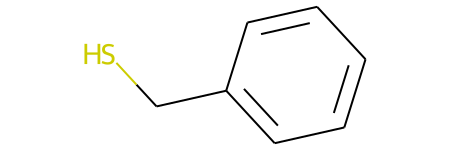

In [13]:
""" 
Annotating and drawing an example sulfur ligand 
"""
u1 = mda.Universe.from_smiles("C1=C(C=CC=C1)CS[H]")
AromaticSulfurSmilesString = 'C1=C(C=CC=C1)CS[H]'
m_aromatic = Chem.MolFromSmiles(AromaticSulfurSmilesString)
#mol_with_atom_index(m_aromatic)
m_aromatic

In [14]:
""" 
Working on the same ligand.. 
"""
# Through RDKIT
AromaticSulfurSmilesString = 'C1=C(C=CC=C1)CS[H]'
m_aromatic = Chem.MolFromSmiles(AromaticSulfurSmilesString)
mol_with_atom_index(m_aromatic)

# Through MDAnalysis 
u1 = mda.Universe.from_smiles(AromaticSulfurSmilesString)
Molecule = u1.select_atoms('all')
Molecule.positions # Finds the cartesian coordinates of the ligands 

array([[ 2.58129507e-01,  1.08698392e+00, -2.84558386e-01],
       [-3.99925917e-01, -1.07918106e-01, -4.76614535e-01],
       [ 1.29618481e-01, -1.25214803e+00,  7.95612186e-02],
       [ 1.28982139e+00, -1.19150233e+00,  8.08403492e-01],
       [ 1.96879256e+00, -2.86334427e-03,  1.01500034e+00],
       [ 1.42227376e+00,  1.14121115e+00,  4.48024482e-01],
       [-1.66099405e+00, -1.37930453e-01, -1.27568078e+00],
       [-3.03754973e+00,  1.26307130e-01, -1.22553803e-01],
       [-1.28988296e-01,  2.00573993e+00, -7.06835151e-01],
       [-4.12408561e-01, -2.18426561e+00, -8.85699093e-02],
       [ 1.68958473e+00, -2.10628986e+00,  1.23800051e+00],
       [ 2.88273525e+00,  4.56632972e-02,  1.58900142e+00],
       [ 1.96292961e+00,  2.08337045e+00,  6.13377154e-01],
       [-1.70347762e+00, -1.11897600e+00, -1.77352822e+00],
       [-1.69635558e+00,  7.03032374e-01, -2.00485229e+00],
       [-2.56418562e+00,  9.09585476e-01,  9.41824555e-01]], dtype=float32)

In [11]:
C70 = mda.Universe.from_smiles("c1(c2c3c4c15)c6c7c8c2c9c%10c3c%11c%12c4c%13c%14c5c%15c6c%16c7c%17c%18c%19c%20c%21c%22c%23c%24c%21c%25c%26c%20c%18c%16c%27c%15c%14c%28c(c%25c%29c%24c%30c%31c%23c%32c%33c%22c%19c%34c%33c(c9c8c%34%17)c%35c%10c%11c(c%31c%32%35)c%36c%12c%13c%28c%29c%30%36)c%26%27")

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/converters/RDKit.py:161: UserWarning: No coordinates found in the RDKit molecule
  warnings.warn("No coordinates found in the RDKit molecule")


In [14]:
C70

<Universe with 70 atoms>

In [32]:
C70.atoms

<AtomGroup with 70 atoms>

In [33]:
# Highlight a Substructure in a Molecule - Can we identify the benzene part and sulfur part?
ConvertedSmiles = Chem.MolToSmiles(Chem.MolFromSmiles('C1=CC=CN=C1'))
ConvertedSmiles
ExampleMartiniString = "CC(=O)CO" # Example smiles string that is compatible with MARTINI 
ConvertedSmiles2 = Chem.MolToSmiles(Chem.MolFromSmiles(ExampleMartiniString))
ConvertedSmiles2
m2  = Chem.MolFromSmiles(ConvertedSmiles2)
# Hence, we need to create a dictionary that catalogues the string with the relevant martini bead 
SmilesToMartiniDictionary = {}
SmilesToMartiniDictionary["CC(=O)CO"] = 'P2' # P2 Bead 
SmilesToMartiniDictionary["CC(=O)O"] = 'SP2' # SP2 Bead 
SmilesToMartiniDictionary["CC(C)O"] = 'P1' # P1 Bead 
SmilesToMartiniDictionary["CC(C)O"] = 'P1' # P1 Bead 

In [34]:
"""
This part links the lignad coordinates with the 
"""
# new feature
u1 = mda.Universe.from_smiles("c1ncncc1C(=O)[O-]")
# new feature
Molecule = u1.select_atoms('all')
Molecule.positions # Finds 
# Need to label each of the xyz coordinates with the relevant indices within the 

array([[-0.5841351 ,  0.84796053,  0.5893585 ],
       [-1.7146647 ,  0.8042749 , -0.14768691],
       [-1.858899  , -0.04390195, -1.1807727 ],
       [-0.82653904, -0.85839343, -1.4599078 ],
       [ 0.31756866, -0.8480727 , -0.75177526],
       [ 0.48483196,  0.01517198,  0.31212032],
       [ 1.7082914 ,  0.05685887,  1.1034952 ],
       [ 1.8439351 ,  0.84458876,  2.0639997 ],
       [ 2.7465043 , -0.79135764,  0.7903003 ],
       [-0.47060382,  1.5331106 ,  1.4221045 ],
       [-2.778046  , -0.04998581, -1.7472394 ],
       [ 1.1317562 , -1.5102541 , -0.9939965 ]], dtype=float32)

In [35]:
m = Chem.MolFromSmiles('c1cc(C(=O)O)c(OC(=O)C)cc1')
substructure = Chem.MolFromSmarts('CC(=O)O')
print(m.GetSubstructMatches(substructure)) # Shows the indices of the molcule that matches the MARTINI bead 

# Find part of the smiles which is part of a ring 

ri = m.GetRingInfo().AtomRings()
for ring in ri:
    print(ring)

((10, 8, 9, 7),)
(0, 12, 11, 6, 2, 1)


In [36]:
"""
In the above situation, we can identify the 3 parts - the thiolated part, the saturated hydrocarbon chain attached 
to the benzene group, and the benzene group itself. 
"""
substructure = Chem.MolFromSmarts('SC')
print(m.GetSubstructMatches(substructure))

()


In [15]:
vector_plot(GenerateCore(10, 100))

In [16]:
"""
Generate an all-atomic based NP 
"""
SphereList = GenerateCore(30, 20)
AromaticSulfurSmilesString = 'C1=C(C=CC=C1)CS[H]'
PandasNPDataframe = AttachLigands('C1=C(C=CC=C1)CS[H]', ['S7'], ['C4'], SphereList)
#PandasNPDataframe = AttachLigandsMartini(MIMILigandPath, 'N1', 'R3', SphereList)
PandasNPDataframe

,X,Y,Z,NAME,name
0,-1.298323e+00,11.480297,-2.260196e-01,C0,Ligand
1,-5.323764e-01,10.830000,7.133668e-01,C1,Ligand
2,5.122400e-01,11.509818,1.303715e+00,C2,Ligand
3,7.552303e-01,12.805227,9.395918e-01,C3,Ligand
4,1.996260e-15,13.476709,5.377889e-16,C4,Ligand
...,...,...,...,...,...
15,-5.488911e-01,-3.032731,-4.235754e+00,Au,Core
16,2.921151e+00,-3.584137,2.461949e+00,Au,Core
17,-3.212475e+00,-4.135543,1.328459e-01,Au,Core
18,1.658247e+00,-4.686949,-1.650177e+00,Au,Core


In [17]:
fig = px.scatter_3d(PandasNPDataframe, x='X', y='Y', z='Z', color='name')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

In [18]:
"""
Generating a Martini based NP 
"""
GroPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/gros"
ItpPath = "/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono"   
MIMILigandPath = GroPath + "/" + "1MIMI.gro"

SphereList = GenerateCore(30, 20)
AromaticSulfurSmilesString = 'C1=C(C=CC=C1)CS[H]'
#PandasNPDataframe = AttachLigands('C1=C(C=CC=C1)CS[H]', ['S7'], ['C4'], SphereList)
PandasNPDataframe = AttachLigandsMartini(MIMILigandPath, 'N1', 'R3', SphereList)
PandasNPDataframe

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/topology/guessers.py:146: UserWarning:

Failed to guess the mass for the following atom types: R



,X,Y,Z,NAME,name
0,-8.193288e-16,3.348379,-1.415723e-16,N1,Ligand
1,-2.157017e-15,6.045137,-6.210692e-16,N2,Ligand
2,3.938000e-01,4.691472,2.305519e+00,R3,Ligand
3,-1.102636e+00,2.995918,1.010105e+00,N1,Ligand
4,-1.990690e+00,5.408806,1.823635e+00,N2,Ligand
...,...,...,...,...,...
15,-1.412873e-01,-0.780640,-1.090305e+00,Au,Core
16,7.519190e-01,-0.922575,6.337181e-01,Au,Core
17,-8.269072e-01,-1.064510,3.419521e-02,Au,Core
18,4.268412e-01,-1.206444,-4.247640e-01,Au,Core


In [19]:
fig = px.scatter_3d(PandasNPDataframe, x='X', y='Y', z='Z', color='name')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

In [159]:
# Need to create an itp from the pandasdataframe

In [21]:
m = Chem.MolFromMolFile('c70.mol') # Read in the C70 mol 
mol1 = u1.atoms.convert_to("RDKIT") # Convert to rdkit 
u = mda.Universe('c70.pdb') # 
mol1 = u.atoms.convert_to("RDKIT", force=True)

/home/sang/anaconda3/lib/python3.8/site-packages/MDAnalysis/converters/RDKit.py:368: UserWarning: No hydrogen atom found in the topology. Forcing to continue the conversion.
  warnings.warn(


In [182]:
!pip install mdparser

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [192]:
import mdparser
mdparser.__dict__

{'__name__': 'mdparser',
 '__doc__': None,
 '__package__': 'mdparser',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f310c4b3130>,
 '__spec__': ModuleSpec(name='mdparser', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f310c4b3130>, origin='/home/sang/anaconda3/lib/python3.8/site-packages/mdparser/__init__.py', submodule_search_locations=['/home/sang/anaconda3/lib/python3.8/site-packages/mdparser']),
 '__path__': ['/home/sang/anaconda3/lib/python3.8/site-packages/mdparser'],
 '__file__': '/home/sang/anaconda3/lib/python3.8/site-packages/mdparser/__init__.py',
 '__cached__': '/home/sang/anaconda3/lib/python3.8/site-packages/mdparser/__pycache__/__init__.cpython-38.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__package__': '',
  '__loader__': _frozen_importlib.BuiltinImporter,
  '__spec__': ModuleSpec(

In [199]:

#from mdparser import topology as mdtop
#from mdparser import tasks as mdtasks

def itpConstraintParser():
    """
    
    """
    file1 = open('/home/sang/Desktop/GIT/Martini3-small-molecules/models/itps/cog-mono/1MIMI_cog.itp', 'r')
    Lines = file1.readlines()
    for i,j  in enumerate(Lines):
        if '[constraints]' in j:
            print(i,j) 

13 [constraints]



In [179]:
gromacs.fileformats.__dict__

{'__name__': 'gromacs.fileformats',
 '__doc__': None,
 '__package__': 'gromacs.fileformats',
 '__loader__': <_frozen_importlib_external.SourceFileLoader at 0x7f310b111c10>,
 '__spec__': ModuleSpec(name='gromacs.fileformats', loader=<_frozen_importlib_external.SourceFileLoader object at 0x7f310b111c10>, origin='/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats/__init__.py', submodule_search_locations=['/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats']),
 '__path__': ['/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats'],
 '__file__': '/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats/__init__.py',
 '__cached__': '/home/sang/anaconda3/lib/python3.8/site-packages/gromacs/fileformats/__pycache__/__init__.cpython-38.pyc',
 '__builtins__': {'__name__': 'builtins',
  '__doc__': "Built-in functions, exceptions, and other objects.\n\nNoteworthy: None is the `nil' object; Ellipsis represents `...' in slices.",
  '__pack

In [22]:
Molecule = mda.Universe('c70.pdb')
mol1 = u.atoms.convert_to("RDKIT", force=True)
C70List = [] 
for index, atoms in enumerate(u.atoms):
    C70List.append(list(atoms.position))
C70List

[[3.973, 0.535, -0.149],
 [3.773, -0.443, -1.066],
 [3.416, -1.699, -0.675],
 [3.228, 0.101, -2.174],
 [2.317, -0.592, -2.906],
 [3.061, 1.417, -1.949],
 [1.982, 2.069, -2.456],
 [3.503, 1.684, -0.702],
 [2.88, 2.634, 0.051],
 [3.809, 0.316, 1.179],
 [3.357, -0.977, 1.625],
 [2.456, -0.799, 2.613],
 [3.189, -1.963, 0.727],
 [2.151, -2.808, 0.82],
 [2.473, -2.406, -1.323],
 [1.711, -3.074, -0.43],
 [1.915, -1.898, -2.439],
 [0.602, -2.029, -2.674],
 [1.192, -0.021, -3.368],
 [0.159, -0.881, -3.235],
 [0.997, 1.299, -3.18],
 [-0.212, 1.78, -2.857],
 [1.276, 2.95, -1.728],
 [-0.042, 2.787, -1.971],
 [1.7, 3.271, -0.491],
 [0.827, 3.43, 0.515],
 [2.607, 2.453, 1.353],
 [1.383, 2.918, 1.635],
 [3.057, 1.237, 1.986],
 [2.247, 0.532, 2.804],
 [0.543, 2.281, 2.647],
 [1.047, 1.019, 3.244],
 [-3.627, 0.321, 2.123],
 [-4.038, -0.018, 0.876],
 [-3.878, 0.843, -0.169],
 [-3.851, -1.344, 0.7],
 [-3.5, -1.84, -0.517],
 [-3.299, -1.838, 1.826],
 [-2.39, -2.848, 1.764],
 [-3.141, -0.813, 2.693],
 [-2.

In [59]:
def ConvertC70Core(coordinate):
    """    
    Description 
    -----------
    
    Creates a MDAnalysis universe from the pdb input of the C70 file, and 
    creates a coarse-grained framework of the C70. 
    
    
    Parameters
    ----------
    coordinate: 
        path and file where the pdb file is.
    filename : str
    copy : bool
    dtype : data-type
    iterable : iterable object
    shape : int or tuple of int
    files : list of str
    
    Returns
    -------
    int
        Description of anonymous integer return value.
    """
    u = mda.Universe(coordinate) # Create Universe 
    CorePositions, CoreIndex = [], [] # Get positions and indices of the core 
    C70CGBeadPositions = [] # list to append the new 'coarse-grained' positions of the C70 Martini NP
    DistanceDict = {} 
    
    CorePositions = [[index, atoms.position] for index, atoms in enumerate(u.atoms)]
    
    for index, atoms in enumerate(u.atoms): # loop over the indices and atoms within the universe 
        DistanceDict[index] = []
        # Get the distance between atoms in the core positions  
        for items in CorePositions: # each element here is [index, atom.position]
            Distance = distance.euclidean(items[1], atoms.position) # get the distance between the atoms and the core
            Entry = [index, items[0], Distance] # index of position A and index of position B, and the distance between 
            DistanceDict[index].append(Entry) # Append this list 
    ClosestAtomsDistance = [] # List to store the atoms with the closest distances
    
    # Sort each entry by distance 
    for key in DistanceDict.keys():
        DistanceDict[key] = sorted(DistanceDict[key], key=itemgetter(2)) # sort entries by closest distance 
        DistanceDict[key][1][0:2] = sorted(DistanceDict[key][1][0:2]) # Get first two index 
        ClosestAtomsDistance.append(DistanceDict[key][1]) 
    
    # Remove duplicate entries 
    UniqueSetsCoordinates = [list(x) for x in set(tuple(x) for x in ClosestAtomsDistance)]       
    
    # Take the indices in the unique data and compute the averge coordinates
    for entry in UniqueSetsCoordinates:
        data = [list(CorePositions[entry[0]][1]), list(CorePositions[entry[1]][1])]
        averaged = np.average(data, axis=0)
        C70CGBeadPositions.append(averaged)
        
        
    return C70CGBeadPositions

def ConstructNPNetwork():
    """
    """
    pass



In [60]:
NPPositions = ConvertC70Core('c70.pdb')
C70 = [[i[0], i[1], i[2]] for i in NPPositions]
C70

[[0.39249998, 1.5395, -3.0185],
 [-3.22, -1.3255, 2.2595],
 [2.67, -2.3855, 0.77349997],
 [-2.4299998, 1.8634999, -1.5074999],
 [-1.606, 0.954, 3.481],
 [-3.0265, -2.316, -0.58150005],
 [0.67550004, -0.451, -3.3014998],
 [-0.352, -3.4235, 1.117],
 [1.7544999, -0.30650002, -3.137],
 [-3.3734999, -0.2395, -1.4844999],
 [-3.575, -1.5910001, 1.263],
 [1.2969999, -2.2680001, 2.3925],
 [-1.8330001, -2.8455, 2.144],
 [-3.9445, -0.681, 0.788],
 [-1.1865, 2.7435, 2.0095],
 [3.273, -1.47, 1.176],
 [3.5005, -0.17099999, -1.62],
 [-3.331, 0.917, 2.2545],
 [-1.7175, -0.22600001, 3.6505],
 [-1.9135001, -1.921, -2.0595],
 [-0.8375, 3.21, -0.313],
 [3.891, 0.42550004, 0.515],
 [0.617, 2.8685, -1.8495],
 [1.629, 2.5095, -2.092],
 [1.6470001, 0.77550006, 3.024],
 [-3.6725001, 0.629, -0.774],
 [-1.1835, -2.3495, 2.967],
 [-3.8325, 0.1515, 1.4994999],
 [0.0075000077, -3.082, -1.2435],
 [-1.3045, 0.26, -2.8885],
 [3.1445, 0.759, -2.0615],
 [-2.273, -3.0545, -0.09700002],
 [0.1355, -0.594, 3.6539998],
 [2.6

In [61]:
"""
Plotting the new C70 core and plotting the 3D scatter plot to see what it looks like
"""
df = pd.DataFrame(NPPositions, columns = ['X','Y','Z'])
fig = px.scatter_3d(df, x='X', y='Y', z='Z')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

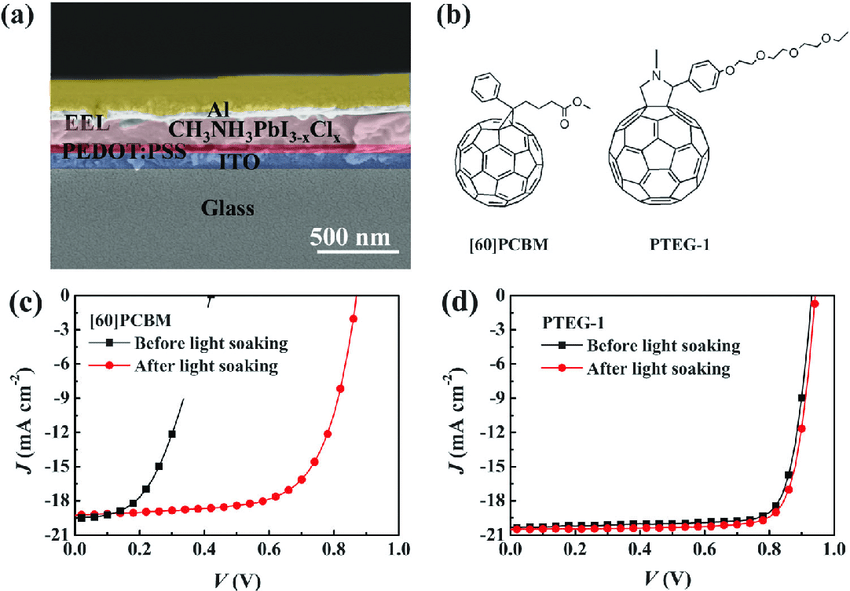

In [40]:
"""
The smiles for the ligand 

Links on information about the C60/C70 ligand bonded NP
-------------------------------------------------------

poly(3-hexyl-thiophene) (P3HT)

phenyl-C-61-butyric acid methyl ester (PCBM).

https://pubchem.ncbi.nlm.nih.gov/compound/3-Hexylthiophene

https://pubchem.ncbi.nlm.nih.gov/compound/6_6_-Phenyl-C61-butyric-acid-methyl-ester

https://chemrxiv.org/engage/chemrxiv/article-details/60c74b9abb8c1a44713db259

https://research.rug.nl/en/publications/resolving-donor-acceptor-interfaces-and-charge-carrier-energy-lev

https://www.americanelements.com/60-pcbm-6-6-phenyl-c61-butyric-acid-methyl-ester-160848-22-6

http://www-jmg.ch.cam.ac.uk/data/molecules/misc/c70.html
 
https://en.wikipedia.org/wiki/Phenyl-C61-butyric_acid_methyl_ester - information on its application
as potential solar cells 

"""


# Which ligand do I need to attach by? 


P3HT = 'CCCCCCC1=CSC=C1'
m_P3HT = Chem.MolFromSmiles(P3HT)
# Universe 
u_P3HT = mda.Universe.from_smiles(P3HT)
# Need to add index 
u_P3HT_object = u_P3HT.select_atoms('all')
#mol_with_atom_index(m_aromatic)

"""
<Atom 1: C0 of type CA resid 1 and segid SYSTEM>
<Atom 2: C1 of type C resid 1 and segid SYSTEM>
<Atom 3: C2 of type C resid 1 and segid SYSTEM>
<Atom 4: C3 of type C resid 1 and segid SYSTEM>
<Atom 5: C4 of type C resid 1 and segid SYSTEM>
<Atom 6: C5 of type C resid 1 and segid SYSTEM>
<Atom 7: C6 of type C resid 1 and segid SYSTEM>
<Atom 8: C7 of type C resid 1 and segid SYSTEM>
<Atom 9: S8 of type S resid 1 and segid SYSTEM>
<Atom 10: C9 of type C resid 1 and segid SYSTEM>
<Atom 11: C10 of type C resid 1 and segid SYSTEM>
<Atom 12: H11 of type H resid 1 and segid SYSTEM>
<Atom 13: H12 of type H resid 1 and segid SYSTEM>
<Atom 14: H13 of type H resid 1 and segid SYSTEM>
<Atom 15: H14 of type H resid 1 and segid SYSTEM>
<Atom 16: H15 of type H resid 1 and segid SYSTEM>
<Atom 17: H16 of type H resid 1 and segid SYSTEM>
<Atom 18: H17 of type H resid 1 and segid SYSTEM>
<Atom 19: H18 of type H resid 1 and segid SYSTEM>
<Atom 20: H19 of type H resid 1 and segid SYSTEM>
<Atom 21: H20 of type H resid 1 and segid SYSTEM>
<Atom 22: H21 of type H resid 1 and segid SYSTEM>
<Atom 23: H22 of type H resid 1 and segid SYSTEM>
<Atom 24: H23 of type H resid 1 and segid SYSTEM>
<Atom 25: H24 of type H resid 1 and segid SYSTEM>
<Atom 26: H25 of type H resid 1 and segid SYSTEM>
<Atom 27: H26 of type H resid 1 and segid SYSTEM>


Testing attaching ligands onto C70 
"""
PCBM = 'C1=CC=CC(=C1)CCCCC(=O)OC'
m_PCBM = Chem.MolFromSmiles(PCBM)
u_PCBM = mda.Universe.from_smiles(PCBM)


LigandList = [] 
Sphere = []
Xplot, Yplot, Zplot = [], [], []
XplotSphere, YplotSphere, ZplotSphere = [], [], []
# Select Atom attached to the core 
#FirstAtom = u_P3HT.select_atoms('name {}'.format('C0')) # Pick out the atoms attached
# Select end atom on the ligand 
#LastAtom = u_P3HT.select_atoms('name {}'.format('S8')) # Pick out the last atom at the tip of the ligand 
#FirstAtom = u_P3HT.select_atoms('name {}'.format('S8')) # Pick out the atoms attached
# Select end atom on the ligand 
#LastAtom = u_P3HT.select_atoms('name {}'.format('C0')) # Pick out the last atom at the tip of the ligand 
FirstAtom = u_PCBM.select_atoms('name {}'.format('C6')) # Pick out the atoms attached
# Select end atom on the ligand 
LastAtom = u_PCBM.select_atoms('name {}'.format('C10')) # Pick out the last atom at the tip of the ligand 
TransformationList, NameList = [], []
# Find the vector representing the direction from the sulfur to the tip of the ligand. 
LigandAlignmentVector = (FirstAtom.positions- LastAtom.positions)[0]
Molecule = u_PCBM.select_atoms('all')
for i,j in enumerate(Molecule.positions):
    vector = (j - FirstAtom.positions)[0]
    vector[0] = LigandAlignmentVector[0] - vector[0]
    vector[1] = LigandAlignmentVector[1] - vector[1]    
    vector[2] = LigandAlignmentVector[2] - vector[2]
    if vector[0] == -math.inf:
        pass
    if vector[0] == 0.0:
        pass
    else:
        TransformationList.append([vector, Molecule.atoms[i].type])      
    
unitVector = np.linalg.norm(LigandAlignmentVector)
vec1 = LigandAlignmentVector.tolist()
for index in range(0, len(C70)):
    vec2 = C70[index] # get cartesian coordinates of the core atom 
    # Find the rotation matrix that aligns ligand vector representation to the NP surface vector point representation 
    TransformationVector = rotation_matrix_from_vectors(vec1, vec2)  
    vec1_rot = TransformationVector.dot(vec1) # Rotate the vector to match the surface point on the sphere 
    # TODO 
    unitVectorabs = np.linalg.norm(LigandAlignmentVector)  
    vecMultiplier = vec1_rot/unitVectorabs * 4 # Controls how far we want the ligands to be placed away from
                                               # the NP surface
    # TODO
    Sphere.append(vec1_rot.tolist())

#LigandList.append(vec1_rot.tolist())
# Get the factors to translate the vector 
for trans in TransformationList:
    #if vec1_rot[0] > 0 and vec1_rot[1] > 0 and vec1_rot[2] > 0:   # (+ , +, +)
    LigandAtomcoordinate = TransformationVector.dot(trans[0])
    LigandAtomcoordinate[0] = LigandAtomcoordinate[0] + vecMultiplier[0]
    LigandAtomcoordinate[1] = LigandAtomcoordinate[1] + vecMultiplier[1]
    LigandAtomcoordinate[2] = LigandAtomcoordinate[2] + vecMultiplier[2]
    LigandList.append(LigandAtomcoordinate.tolist()) # Append coordinates of the 
    NameList.append(trans[1]) # Append the names of the atoms 
        
# Append the coordinates of the ligands 
for index, entry in enumerate(LigandList):
    #ax.plot3D(entry[0], entry[1], entry[2], 'red')
    Xplot.append(entry[0])
    Yplot.append(entry[1])
    Zplot.append(entry[2])
# Add in the ligand index 
LigandConstituent = [atom.name for atom in Molecule]
Ligands = []
for index in range(0, len(Sphere)): 
    Ligands = Ligands + LigandConstituent
    
SphereName = [] 
# Append the coordinates of the sphere 
for entry in Sphere:
    #ax.plot3D(entry[0], entry[1], entry[2], 'red')
    XplotSphere.append(entry[0])
    YplotSphere.append(entry[1])
    ZplotSphere.append(entry[2])
    SphereName.append('Au')
    
dfLigand = pd.DataFrame(list(zip(Xplot, Yplot, Zplot, Ligands)), columns =['X', 'Y', 'Z', 'NAME'])
dfLigand['name'] = 'Ligand'
dfCore = pd.DataFrame(list(zip(XplotSphere, YplotSphere, ZplotSphere, SphereName)), columns =['X', 'Y', 'Z', 'NAME'])
dfCore['name'] = 'Core'
Total = dfLigand.append(dfCore)


TypeError: object of type 'Universe' has no len()

In [77]:
Total

,X,Y,Z,NAME,name
0,5.960394,-3.473137,0.851449,C0,Ligand
1,6.119952,-2.117413,0.640176,C1,Ligand
2,6.610378,-1.682692,-0.590572,C2,Ligand
3,6.938083,-2.575874,-1.597337,C3,Ligand
4,6.779544,-3.911732,-1.385665,C4,Ligand
...,...,...,...,...,...
40,2.935128,-3.844288,-1.229751,Au,Core
41,-3.917849,2.962100,0.884443,Au,Core
42,4.238599,2.002422,-1.711841,Au,Core
43,3.915089,-1.196146,2.854317,Au,Core


In [78]:
fig = px.scatter_3d(Total, x='X', y='Y', z='Z', color='name')
#fig = px.scatter_3d(dfCore, x='X', y='Y', z='Z')
fig.show()

In [51]:
GenerateXYZ(Total, 'new.xyz')

In [34]:
vector

array([-16.936071  ,   0.21350878,  -2.7219892 ], dtype=float32)

In [23]:
for i in u_P3HT.atoms:
    print(i)

<Atom 1: C0 of type CA resid 1 and segid SYSTEM>
<Atom 2: C1 of type C resid 1 and segid SYSTEM>
<Atom 3: C2 of type C resid 1 and segid SYSTEM>
<Atom 4: C3 of type C resid 1 and segid SYSTEM>
<Atom 5: C4 of type C resid 1 and segid SYSTEM>
<Atom 6: C5 of type C resid 1 and segid SYSTEM>
<Atom 7: C6 of type C resid 1 and segid SYSTEM>
<Atom 8: C7 of type C resid 1 and segid SYSTEM>
<Atom 9: S8 of type S resid 1 and segid SYSTEM>
<Atom 10: C9 of type C resid 1 and segid SYSTEM>
<Atom 11: C10 of type C resid 1 and segid SYSTEM>
<Atom 12: H11 of type H resid 1 and segid SYSTEM>
<Atom 13: H12 of type H resid 1 and segid SYSTEM>
<Atom 14: H13 of type H resid 1 and segid SYSTEM>
<Atom 15: H14 of type H resid 1 and segid SYSTEM>
<Atom 16: H15 of type H resid 1 and segid SYSTEM>
<Atom 17: H16 of type H resid 1 and segid SYSTEM>
<Atom 18: H17 of type H resid 1 and segid SYSTEM>
<Atom 19: H18 of type H resid 1 and segid SYSTEM>
<Atom 20: H19 of type H resid 1 and segid SYSTEM>
<Atom 21: H20 of t

In [36]:
SphereList = GenerateCore(10, 20)
SphereList

[[0.0, 10.0, 0.0],
 [-3.293043372158504, 8.947368421052632, 3.0166974801980206],
 [0.5366054686279798, 7.894736842105264, -6.114342545600823],
 [4.437250612693587, 6.842105263157895, 5.787607672261262],
 [-8.029008272447404, 5.7894736842105265, -1.4202185116400012],
 [7.430908708905336, 4.736842105263158, -4.726935860546545],
 [-2.4134348850096936, 3.68421052631579, 8.977857475678826],
 [-4.446613324391361, 2.6315789473684212, -8.561683373444298],
 [9.275384024876669, 1.578947368421053, 3.3873553694318743],
 [-9.230644113001569, 0.5263157894736847, 3.8102757050980163],
 [4.232585436290039, -0.5263157894736836, -9.044789229952027],
 [2.955296325164402, -1.578947368421053, 9.421950373368883],
 [-8.347149180670506, -2.6315789473684204, -4.837343568468028],
 [9.079754606968212, -3.68421052631579, -1.9961585796282524],
 [-5.065134773100864, -4.7368421052631575, 7.204632995519659],
 [-1.047831076633954, -5.7894736842105265, -8.086040099744368],
 [5.576466989837349, -6.842105263157894, 4.6998

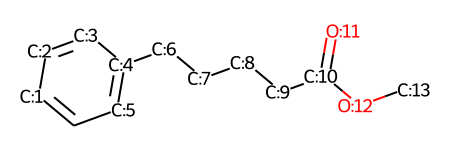

In [38]:
# C70
Phenyl_C61_Butyric_Acid_Methyl_Ester = 'C1=CC=CC(=C1)CCCCC(=O)OC'
C70BAME = Chem.MolFromSmiles(Phenyl_C61_Butyric_Acid_Methyl_Ester)
u_C70BAME = mda.Universe.from_smiles(Phenyl_C61_Butyric_Acid_Methyl_Ester)
# Need to add index 
u_C70BAME_object = u_C70BAME.select_atoms('all')
#u_C70BAME_object.write("u_C70BAME.xyz")
mol_with_atom_index(C70BAME) # C6 is the attaching ligand 

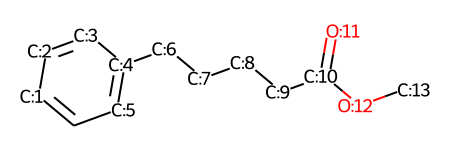

In [41]:
PCBM = 'C1=CC=CC(=C1)CCCCC(=O)OC'
m_PCBM = Chem.MolFromSmiles(PCBM)
mol_with_atom_index(m_PCBM)

#u_PCBM = mda.Universe.from_smiles(PCBM)
#for i in u_PCBM.select_atoms('all'):
#    print(i)
    


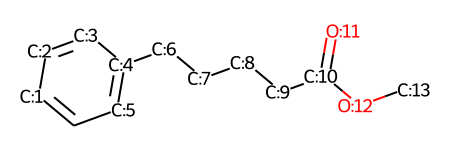

In [17]:
m_PCBM

In [ ]:
# https://stackoverflow.com/questions/53075481/how-do-i-cluster-a-list-of-geographic-points-by-distance


import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import math

points = np.array([[33.    , 41.    ],
       [33.9693, 41.3923],
       [33.6074, 41.277 ],
       [34.4823, 41.919 ],
       [34.3702, 41.1424],
       [34.3931, 41.078 ],
       [34.2377, 41.0576],
       [34.2395, 41.0211],
       [34.4443, 41.3499],
       [34.3812, 40.9793]])


def distance(origin, destination): #found here https://gist.github.com/rochacbruno/2883505
    lat1, lon1 = origin[0],origin[1]
    lat2, lon2 = destination[0],destination[1]
    radius = 6371 # km
    dlat = math.radians(lat2-lat1)
    dlon = math.radians(lon2-lon1)
    a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) \
        * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    d = radius * c

    return d

def create_clusters(number_of_clusters,points):
    kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(points)
    l_array = np.array([[label] for label in kmeans.labels_])
    clusters = np.append(points,l_array,axis=1)
    return clusters

def validate_solution(max_dist,clusters):
    _, __, n_clust = clusters.max(axis=0)
    n_clust = int(n_clust)
    for i in range(n_clust):
        two_d_cluster=clusters[clusters[:,2] == i][:,np.array([True, True, False])]
        if not validate_cluster(max_dist,two_d_cluster):
            return False
        else:
            continue
    return True

def validate_cluster(max_dist,cluster):
    distances = cdist(cluster,cluster, lambda ori,des: int(round(distance(ori,des))))
    print(distances)
    print(30*'-')
    for item in distances.flatten():
        if item > max_dist:
            return False
    return True

if __name__ == '__main__':
    for i in range(2,len(points)):
        print(i)
        print(validate_solution(20,create_clusters(i,points)))


In [96]:
DistIndex1Index2
UniqueIndex1Index2Distances = [list(i) for i in list(set(map(tuple, DistIndex1Index2)))]

NameError: name 'DistIndex1Index2' is not defined

In [9]:
import os                                                                                                                                                                                                  
import numpy as np                                                                                                                                                                                         
import itertools                                                                                                                                                                                           
import requests                                                                                                                                                                                            
import collections                                                                                                                                                                                         
import random                                                                                                                                                                                              
                                                                                                                                                                                                           
# RDKit libaries                                                                                                                                                                                           
from rdkit import Chem                                                                                                                                                                                     
from rdkit.Chem import AllChem                                                                                                                                                                             
from rdkit.Chem import ChemicalFeatures                                                                                                                                                                   
from rdkit.Chem import rdchem                                                                                                                                                                              
from rdkit.Chem import rdMolDescriptors                                                                                                                                                                    
from rdkit import RDConfig                                                                                                                                                                                 
                                                                                                                                                                                                           
# Boilerplate libraries                                                                                                                                                                                    
import sys                                                                                                                                                                                                 
import re                                                                                                                                                                                                  
import math                                                                                                                                                                                                
import scipy                                                                                                                                                                                               
                                                                                                                                                                                                           
# scipy libaries                                                                                                                                                                                           
from scipy.sparse import csr_matrix                                                                                                                                                                        
from scipy.sparse.csgraph import floyd_warshall                                                                                                                                                            
from scipy.spatial import ConvexHull, convex_hull_plot_2d           

def read_DG_data(DGfile):                                                                                                                                                                                  
    # Reads Delta G_OW for fragments into dictionary                                                                                                                                                       
    DG_data = {}                                                                                                                                                                                           
    with open(DGfile) as f:                                                                                                                                                                                
        for line in f:                                                                                                                                                                                     
            (key,val) = line.rstrip().split()                                                                                                                                                              
            DG_data[key] = float(val)                                                                                                                                                                      
                                                                                                                                                                                                           
    return DG_data                                                                                                                                                                                         
                                                                                                                                                                                                           
def include_weights(A,w):                                                                                                                                                                                  
    # Weights atoms by setting diagonal components                                                                                                                                                         
    A_weighted = np.copy(A)                                                                                                                                                                                
    for i,weight in enumerate(w):                                                                                                                                                                          
        A_weighted[i,i] = weight     
        
def get_smarts_matches(mol):                                                                                                                                                                               
    #Get matches to SMARTS strings                                                                                                                                                                         
    smarts_strings = {                                                                                                                                                                                     
    'S([O-])(=O)(=O)O'  :    'Qa',                                                                                                                                                                         
    'S([O-])(=O)(=O)[C;!$(*F)]'   :    'Q0'}                                                                                                                                                               
    matched_maps = []                                                                                                                                                                                      
    matched_beads = []                                                                                                                                                                                     
    for smarts in smarts_strings:                                                                                                                                                                          
        matches = mol.GetSubstructMatches(Chem.MolFromSmarts(smarts))                                                                                                                                      
        for match in matches:                                                                                                                                                                              
            matched_maps.append(list(match))                                                                                                                                                               
            matched_beads.append(smarts_strings[smarts])                                                                                                                                                   
                                                                                                                                                                                                           
    return matched_maps,matched_beads           

In [130]:
DataPath = '/home/sang/Desktop/GIT/MDNPPackage/temp/cgparam/fragment_DGs.dat'

In [131]:
read_DG_data(DataPath)

{'CC': 8.2656,
 'CN': -6.0844,
 'CO': -7.9212,
 'CF': 2.3534,
 'CCl': 3.8458,
 'C=C': 5.166,
 'C=O': -3.9032,
 'C#C': -0.1722,
 'CCC': 12.5706,
 'CCN': -1.148,
 'CCO': -2.296,
 'CCF': 5.7974,
 'CCCl': 8.4378,
 'FCF': 1.6646,
 'FCCl': 3.5588,
 'ClCF': 3.5588,
 'ClCCl': 6.4288,
 'CNC': -3.0422,
 'COC': -0.9184,
 'CC=C': 9.6432,
 'CC=O': -0.0574,
 'CC#N': -0.2296,
 'NC=N': -8.036,
 'NC=O': -8.7822,
 'OC=O': -2.6978,
 'FC=C': 5.8548,
 'ClC=C': 8.2082,
 'NN=C': -1.8368,
 'ON=C': -1.7794,
 'CC#C': 5.2808,
 'CC(C)C': 12.3984,
 'CC(C)N': -0.287,
 'CC(C)O': 0.2296,
 'CC(C)F': 6.1992,
 'CC(C)Cl': 8.5526,
 'CC(F)F': 4.5346,
 'CC(F)Cl': 7.2898,
 'CC(Cl)F': 7.2898,
 'CC(Cl)Cl': 9.8728,
 'FC(F)F': 5.5678,
 'FC(F)Cl': 5.6252,
 'FC(Cl)F': 5.6252,
 'FC(Cl)Cl': 7.3472,
 'ClC(F)F': 5.6252,
 'ClC(F)Cl': 7.3472,
 'ClC(Cl)F': 7.3472,
 'ClC(Cl)Cl': 9.5858,
 'CN(C)C': -0.8036,
 'CC(C)=C': 10.7338,
 'CC(C)=O': -1.6646,
 'CC(N)=N': -5.74,
 'CC(N)=O': -6.314,
 'CC(O)=O': -0.6888,
 'CC(F)=C': 7.4046,
 'CC(Cl)=C':

In [ ]:
def write_gro(mol_name,bead_types,coords0,gro_name):                                                                                                                                                       
    #write gro file                                                                                                                                                                                        
    conf = mol.GetConformer(0)                                                                                                                                                                             
    with open(gro_name,'w') as gro:                                                                                                                                                                        
        gro.write('single molecule of {}\n'.format(mol_name))                                                                                                                                              
        gro.write('{}\n'.format(len(bead_types)))                                                                                                                                                          
        i = 1                                                                                                                                                                                              
        for bead,xyz in zip(bead_types,coords0):                                                                                                                                                           
            gro.write('{:5d}{:5}{:>5}{:5d}{:8.3f}{:8.3f}{:8.3f}\n'.format(1,mol_name,bead,i,xyz[0],xyz[1],xyz[2]))                                                                                         
            i += 1                                                                                                                                                                                         
        gro.write('5.0 5.0 5.0')         